<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Session 8: Machine Learning Pipelines</span></div>

by BYJ Cirio

<div class="alert alert-danger alert-info">
     In this notebook you will learn how to automate your machine learning model pipelines. Specifically, the topics covered are as follows:<br>
    <ol>
        <li>Auto-ML</li>
        <li>Grid-search CV/Randomized Search CV</li>
        <li>Example project</li>
    </ol>
</div>

In [1]:
# General Libraries
import re
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN

# SHAP
import shap

In [2]:
df = pd.read_csv('transactions_clean_onehot.csv')
df['diff_datetime_hrs'] = df['diff_datetime_hrs'].fillna(0)
df.head()

,Unnamed: 0,is_fraud,diff_datetime_hrs,prev_fraud,amt,city_pop,age,dist_to_merch_in_kms,category_entertainment,category_food_dining,...,city_San Pedro,city_Santa Rosa,city_Sorsogon,city_Surigao,city_Tacloban,city_Taguig City,city_Tagum,city_Tandag,city_Tarlac City,city_Valenzuela
0,0,0,0.0,0.0,115.58,574089,83,66.720087,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,7.0,0.0,4.35,574089,83,89.750504,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0.0,0.0,4.65,574089,83,31.625560,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,13.0,0.0,32.87,574089,83,112.130879,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1.0,0.0,192.43,574089,83,101.931179,0,0,...,0,0,0,0,0,0,0,0,0,0


Would Recommend:       0
0  89155
1    495
Proportion Chance Criterion: 98.90%
1.25 * Proportion Chance Criterion: 123.63%


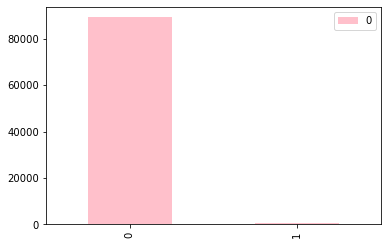

In [3]:
state_counts = Counter(df['is_fraud'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='pink')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

In [4]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y)

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Auto-ML </span></div>

In [5]:
# models_dict = {'GaussianNB': GaussianNB(),
#               'RandomForestClassifier': RandomForestClassifier(random_state=143)}

models_dict = {
    'LogisticRegressor': LogisticRegression(C=1),
    #'RandomForestClassifier': RandomForestClassifier(random_state=11),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=7),
    #'GradientBoostingClassifier': GradientBoostingClassifier(random_state=11)   
}
# models_dict = {
#     'KNeighborsClassifier': KNeighborsClassifier(),
#     'LogisticRegressor': LogisticRegression(),
#     'GaussianNB': GaussianNB(),
#     'RandomForestClassifier': RandomForestClassifier(random_state=143),
#     'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
#     'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)   
# }

In [6]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

### Baseline

In [7]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
               cv=StratifiedKFold(n_splits=5))
auto = auto_run[0]
auto_run[1]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,99.81%,99.77%,74.73%,69.54%,1.351731
DecisionTreeClassifier,99.99%,99.95%,98.85%,95.95%,1.035229


### Applying resampling techniques

#### Oversampling

In [9]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                    cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------SMOTE---------------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.629497766494751
Resampling done in 0.6636099815368652
Resampling done in 0.6037554740905762
Resampling done in 0.5765619277954102
Resampling done in 0.8886168003082275


0it [00:00, ?it/s]

Resampling done in 0.7012872695922852
Resampling done in 0.5794122219085693
Resampling done in 0.6135737895965576
Resampling done in 0.6572380065917969
Resampling done in 0.7088618278503418


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,97.57%,96.13%,98.87%,83.29%,7.191084
DecisionTreeClassifier,99.96%,99.88%,100.00%,97.03%,4.610955


--------------------------------------------------ADASYN---------------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 1.330336093902588
Resampling done in 0.877267599105835
Resampling done in 0.8808207511901855
Resampling done in 0.9887487888336182
Resampling done in 1.3675768375396729


0it [00:00, ?it/s]

Resampling done in 0.9735314846038818
Resampling done in 1.2985248565673828
Resampling done in 0.9494550228118896
Resampling done in 0.9015517234802246
Resampling done in 0.8747842311859131


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,97.57%,95.88%,99.14%,83.83%,6.92194
DecisionTreeClassifier,99.96%,99.89%,100.00%,96.76%,3.417117


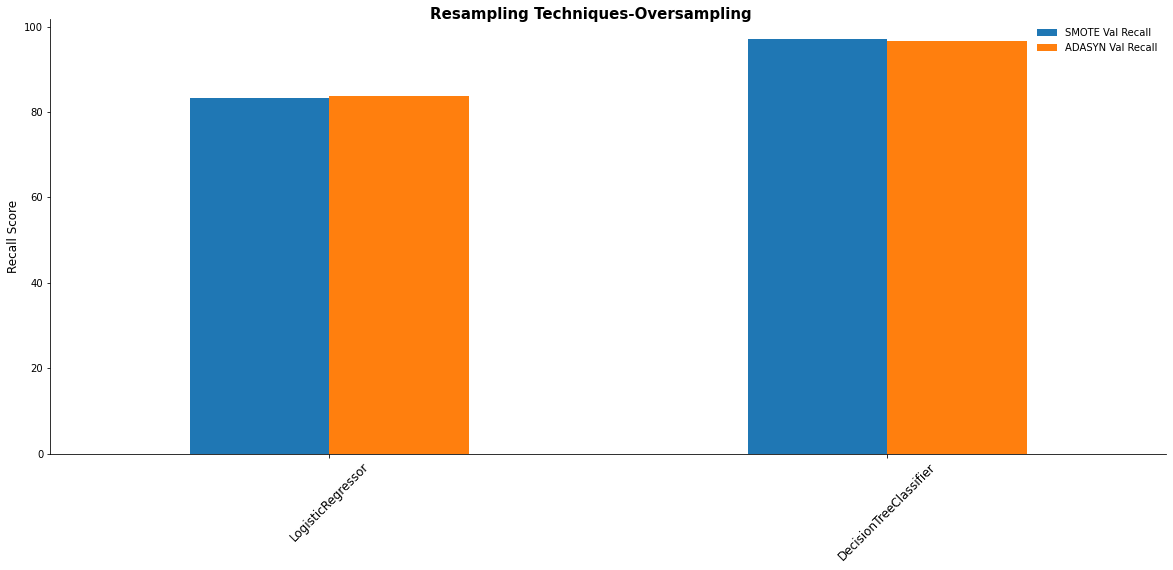

In [10]:
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Undersampling

In [11]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

------------------------------------------------TomekLinks-------------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 26.46421456336975
Resampling done in 27.492138385772705
Resampling done in 24.474334955215454
Resampling done in 25.52868413925171
Resampling done in 24.29196000099182


0it [00:00, ?it/s]

Resampling done in 26.30506920814514
Resampling done in 26.43387794494629
Resampling done in 23.773077487945557
Resampling done in 24.614093542099
Resampling done in 28.621811866760254


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,99.81%,99.77%,74.80%,70.08%,1.05819
DecisionTreeClassifier,99.99%,99.96%,98.85%,97.03%,3.186787


-------------------------------------------------NearMiss--------------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.7859017848968506
Resampling done in 0.6158764362335205
Resampling done in 0.6419262886047363
Resampling done in 0.7400157451629639
Resampling done in 0.6716220378875732


0it [00:00, ?it/s]

Resampling done in 0.646378755569458
Resampling done in 0.7556664943695068
Resampling done in 0.5456118583679199
Resampling done in 0.6093711853027344
Resampling done in 0.5574753284454346


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,93.40%,45.56%,89.82%,89.23%,0.065819
DecisionTreeClassifier,100.00%,70.70%,100.00%,99.46%,0.046868


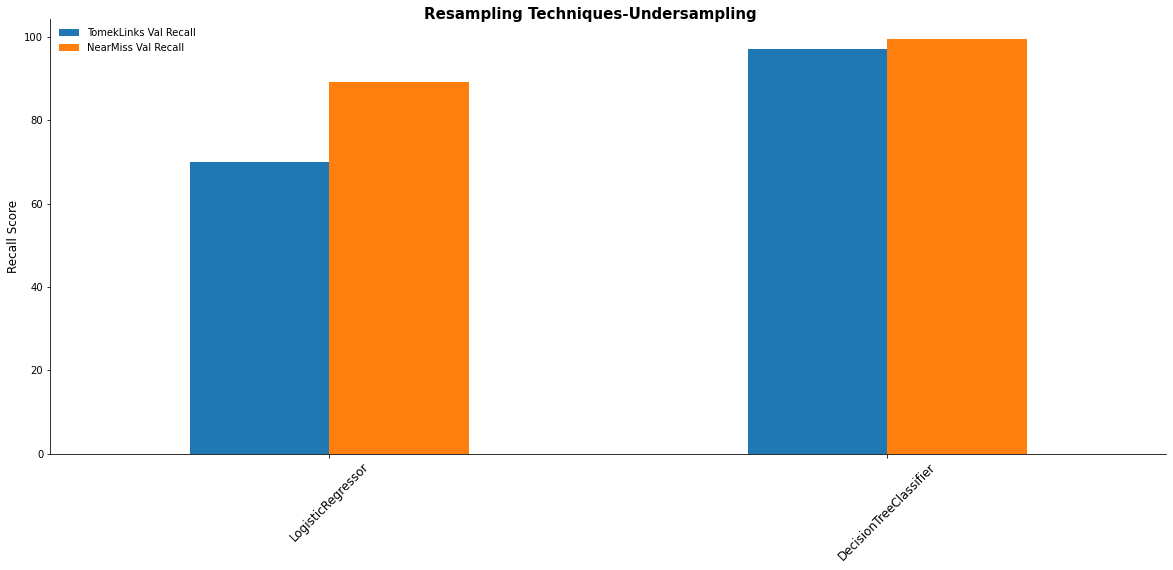

In [12]:
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']

fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Grid-Search and Randomized Search Cross Validation </span></div>

[Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [Randomized Search Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) are commonly used to hypertune models across multiple parameters

In [13]:
def train_rf(X, y, metric, res_t=None, hypertune=False, resample=False):
    """Hypertune Random Forest and apply TomekLinks()"""
    params = {#'n_estimators': [50, 100, 150, 200],
              #'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': list(range(3, 20))
              }
    new_params = {'decisiontreeclassifier__' +
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      res_t,
                                      DecisionTreeClassifier(random_state = 11))
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      DecisionTreeClassifier(random_state = 11))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['Decision Tree Classifier', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['Decision Tree Classifier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

In [14]:
start_time = time.time()
rf_tmk_rec = train_rf(X_trainval, y_trainval, 'recall', TomekLinks(),
                       hypertune=True, resample=True)
start_time = time.time()
rf_tmk_acc = train_rf(X_trainval, y_trainval, 'accuracy', TomekLinks(),
                      hypertune=True, resample=True)

Fitting 5 folds for each of 17 candidates, totalling 85 fits
[CV 1/5; 1/17] START decisiontreeclassifier__max_depth=3........................
[CV 1/5; 1/17] END decisiontreeclassifier__max_depth=3;, score=(train=0.919, test=0.824) total time=  24.0s
[CV 2/5; 1/17] START decisiontreeclassifier__max_depth=3........................
[CV 2/5; 1/17] END decisiontreeclassifier__max_depth=3;, score=(train=0.905, test=0.893) total time=  26.4s
[CV 3/5; 1/17] START decisiontreeclassifier__max_depth=3........................
[CV 3/5; 1/17] END decisiontreeclassifier__max_depth=3;, score=(train=0.892, test=0.946) total time=  27.1s
[CV 4/5; 1/17] START decisiontreeclassifier__max_depth=3........................
[CV 4/5; 1/17] END decisiontreeclassifier__max_depth=3;, score=(train=0.902, test=0.905) total time=  25.5s
[CV 5/5; 1/17] START decisiontreeclassifier__max_depth=3........................
[CV 5/5; 1/17] END decisiontreeclassifier__max_depth=3;, score=(train=0.892, test=0.865) total time=  

In [34]:
rf_tmk_rec['Best parameters']

TypeError: list indices must be integers or slices, not str

In [15]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [rf_tmk_rec[0],
                np.round(rf_tmk_acc[1]*100, 6),
                np.round(rf_tmk_acc[2]*100, 6),
                np.round(rf_tmk_rec[1]*100, 6),
                np.round(rf_tmk_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [rf_tmk_rec[0],
                 '{:.2f}%'.format(np.round(rf_tmk_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
Decision Tree Classifier,99.98%,99.95%,98.20%,96.76%


In [16]:
# re-fitting for the holdout
rh = rf_tmk_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)

#### Base-case

In [17]:
# cross-validation
base_var = train_rf(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [18]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(rf_tmk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,100.00%,95.95%,98.39%
Resampling x Hypertune,98.20%,96.76%,98.39%


In [20]:
holdout_ascore = rh.score(X_holdout, y_holdout)

In [22]:
holdout_ascore*100

99.97769151831525

AttributeError: 'Pipeline' object has no attribute 'best_params_'

In [46]:
rf_tmk_rec

['Decision Tree Classifier',
 0.9820082114199761,
 0.9675675675675676,
 "Best parameters = {'decisiontreeclassifier__max_depth': 7}",
 2530.852865457535,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('tomeklinks', TomekLinks()),
                 ('decisiontreeclassifier',
                  DecisionTreeClassifier(max_depth=7, random_state=11))])]

AttributeError: 'DecisionTreeClassifier' object has no attribute 'tree_'